# SLT-CE-2: Sampling

# Introduction

## Task

In this coding exercise we will test various MCMC sampling procedures [1] introduced during the tutorial session. We will try to solve the image reconstruction problem. Given a noisy [binary image](https://en.wikipedia.org/wiki/Binary_image) one needs to recover the original through denoising. To do so we will use the prototypical [Ising model](https://en.wikipedia.org/wiki/Ising_model) from physics as explained in section 8.3.3 of [2]. An undirected graphical model is designed to model (i) the adherence of the reconstruction to the observed noisy image and (ii) the correlation between neighboring pixels. We are interested in recovering a single image, the most likely one, with respect to the underlying distribution i.e. we do MAP inference to discover the peak of the posterior distribution $p(image\_reconstruction | noisy\_observation)$.


### References 

[1] http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf

[2] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

## Model

Given a noisy, binary image $y=(y_1,\dots,y_n)$ where $y_i\in\{\pm1\}$ is the value of the i-th pixel, the Ising model tries to find a denoised image $x=(x_1,\dots,x_n)$ by minimizing the following energy function:

$$E(x,y) = - h \sum_{i} x_i - \beta \sum_{i,j \in N_i} x_i x_j - \eta \sum_{i} x_i y_i$$

where $N_i$ is the set of neighbors of pixel $i$. For a 2D image the pixel neighbourhood $N_i$ usually involves 4 or 8 surrounding pixels. You should try out both options during this exercise, and see which one works better. The undirected probabilistic graphical model from where the energy function $E(x,y)$ is derived is in more detail explained in [2].

## Setup

We start by importing necessary python packages.

In [96]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pylab as plt
from scipy.ndimage import convolve
import time
import random

We load the original image of size 300x300 which we will be trying to reconstruct. White pixels have values -1 and the black pixels are of value +1.

In [2]:
IMG_ORIGINAL = mpimg.imread("flower.png")#[:,:,0]/255
IMG_ORIGINAL[IMG_ORIGINAL > 0.5] = 1
IMG_ORIGINAL[IMG_ORIGINAL <= 0.5] = -1

Check the dimensions of the image

In [3]:
IMG_HEIGHT = IMG_ORIGINAL.shape[0]
IMG_WIDTH = IMG_ORIGINAL.shape[1]
IMG_ORIGINAL.shape

(300, 300)

Plot the original image

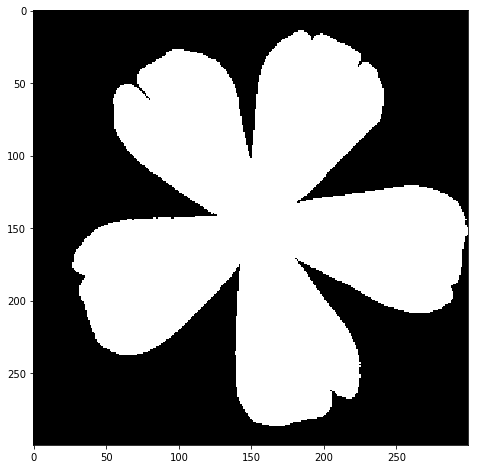

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_ORIGINAL, cmap='gray')
plt.show()

Generate the noisy version - flip random 30% of pixels. 

In [8]:
# Fix random seed for reproducibility
np.random.seed(13)

IMG_NOISY_OBSERVATION = IMG_ORIGINAL.copy()
num_flips = int(0.3 * IMG_HEIGHT * IMG_WIDTH)

perm = np.random.permutation(IMG_ORIGINAL.size)[0:int(0.3 * IMG_ORIGINAL.size)]
for k in perm:
    i = int(k/IMG_WIDTH)
    j = k%IMG_HEIGHT
    IMG_NOISY_OBSERVATION[i,j] = -IMG_NOISY_OBSERVATION[i,j]

Plot the noisy version of the original image

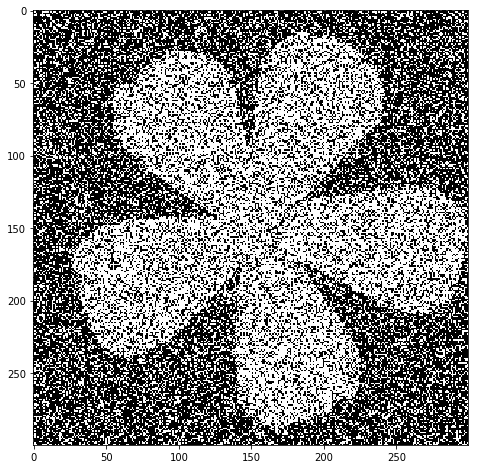

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_NOISY_OBSERVATION, cmap='gray')
plt.show()

Finally, in this exercise we do not care about learning the right model from the data, but only about inferring the most likely state, the one with the minimum energy. Thus we will fix parameters of the model as given in [2].

In [10]:
H = 0.0
Beta = 1.0
Eta = 2.1

# Problems:

Solve all the problems to get 1 point, and an extension at the end of the notebook to get an extra point. Note that above all, we will validate the working code. If most of the exercise is successfully completed you will be fully compensated. In addition, make sure that all the code can be executed in a reasonable time meaning approx. less than 2mins, otherwise you might want to do some changes in your implementation.

## Problem 0

Shortly describe, in a few sentences, and give the corresponding formulas for the following sampling procedures which you will be consequently trying to implement in the rest of this exercise. Add text in each bullet. See [markdown cheatsheet](https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed) for text editing.
- Metropolis:



- Heathbath:
- Simulated Annealing:
- Parallel Tempering

## Problem 1

Firstly, to be able to search for the state which minimizes the energy of our model, we need to be able to compute the energy. This is done with respect to the model described at the beginning of the notebook. We also want to have a certain quantification of our reconstruction, to measure how far is our reconstruction estimate from the original. For this, we will use [Mean Squared Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error). Implement the two following functions. Also feel free to add any additional auxilary functions which will be used in the rest of the exercise.

In [71]:
def energy(img_estimate, img_noisy_observation):
    """Compute the energy for given estimate 'img_estimate' which
    is our vector x in the original model, with respect to the 
    observation 'img_noisy_observation', vector y in the model.

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
            energy (float): energy of the estimate given observation
    """
    # Your code comes here

    # Energy1 between images: -eta*y_i*x_i
    E1 = -Eta*img_estimate.flatten()*img_noisy_observation.flatten()
    
    X = img_estimate
    Y = img_noisy_observation
    
    m1,n1 = X.shape
    m2,n2 = Y.shape
    
    
    
    E1, E2, E3 = 0,0,0
    neighbors = [(-1, -1), (0, -1), (1, -1),
             (-1, 0), (0, 0), (1, 0), 
             (-1, 1), (0, 1), (1, 1)
            ]
    for i in range(m1):
        for j in range(n1):            
            E1 += X[i,j]
            for (p1, p2) in neighbors:
                k = i + p1
                l = j + p2
                if p1 == 0 and p2 == 0:
                    E2 += X[i,j]*Y[i,j]
                elif 0 <= k < m2  and 0 <= l < n2:
                    E3 += X[i,j]*Y[k,l]
    E = H*E1 + Beta*E2 + Eta*E3
    return E

In [72]:
def mse_loss(img_estimate, img_original):
    """Computing mean squared error loss

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_original (np.ndarray): original image matrix

    Returns:
            mse (float): mean squared error between two matrices
    """
    # Your code comes here
    val = 0
    m,n = img_estimate.shape
    for i in range(m):
        for j in range(n):
            val += (img_estimate[i,j] - img_original[i,j])**2
    return val/(m+n)

In [86]:
# Any auxiliary functions may be placed here..

def local_energy(img_estimate, img_noisy_observation, i, j):
    """Compute the local energy for a given pixel
    """
    # Your code comes here

    # Energy1 between images: -eta*y_i*x_i
    E1 = -Eta*img_estimate.flatten()*img_noisy_observation.flatten()
    
    X = img_estimate
    Y = img_noisy_observation
    
    m1,n1 = X.shape
    m2,n2 = Y.shape
    
    
    
    E1, E2, E3 = 0,0,0
    neighbors = [(-1, -1), (0, -1), (1, -1),
             (-1, 0), (0, 0), (1, 0), 
             (-1, 1), (0, 1), (1, 1)
            ]

    E1 += X[i,j]
    for (p1, p2) in neighbors:
        k = i + p1
        l = j + p2
        
        if p1 == 0 and p2 == 0:
            E2 += X[i,j]*Y[i,j]
        elif 0 <= k < m2  and 0 <= l < n2:
            E3 += X[i,j]*Y[k,l]
    E = H*E1 + Beta*E2 + Eta*E3
    return E

Display various energies and losses for the noisy image as our initial estimate with respect to the original image.

In [97]:
print(mse_loss(IMG_NOISY_OBSERVATION, IMG_ORIGINAL))
print(energy(IMG_ORIGINAL, IMG_NOISY_OBSERVATION))
print(energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION))
m,n = IMG_NOISY_OBSERVATION.shape
i,j = random.randint(0,m), random.randint(0,n)
print(local_energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION, i, j))

179.923333333
620495.8
323425.0
5.2


## Problem 2

Implement metropolis sampling.

In [80]:
def pDist(energy):
    return np.exp(- energy)

# metropolis():

# p_X unnormalized probability distribution
# V: proposal distribution
# function MetropolisHastings(p_X, V )
#  x ← any valid value
#  loop
#   x' ←Sample from V (·|x)
#   a ← min {1, p(x')/p(x) * V(x|x')/V(x'|x)} 
#   with probability a: x <- x'

def metropolis(img_noisy_observation, img_original, epochs):
    """Do the metropolis sampling starting from noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code
    energies = []
    losses = []
    E = energy(img_noisy_observation, img_noisy_observation)
    L = mse_loss(img_noisy_observation, img_original)
    m,n = img_noisy_observation.shape
    # artifically construct energies and losses arrays
    for i in range(1000):
        if i % 10 == 0:
            print("Current % done: {}".format(int(i/10)))
        energies.append(E)
        losses.append(L)
        
        rand_i,rand_j = np.random.randint(0,m,1), np.random.randint(0,n,1)
        img_noisy_prop = img_noisy_observation
        #actually we would only need neighboring pixels to calculate energy distribution
        img_noisy_prop[rand_i, rand_j] = (img_noisy_prop[rand_i, rand_j] + 1) % 2
        E_prop_local = local_energy(img_noisy_prop, img_noisy_observation, rand_i, rand_j)
        E_local = local_energy(img_noisy_observation, img_noisy_observation, rand_i, rand_j)
        a = pDist(E_prop_local)/pDist(E_local)
        print("a: {} | E_prop_local: {} | E_local: {}".format(a, E_prop_local, E_local))
        if np.random.random() < a:
            img_noisy_observation = img_noisy_prop
            energies.append(energy(img_noisy_prop, img_noisy_observation))
        
    return img_noisy_observation, np.asarray(energies), np.asarray(losses)

## Problem 3

Implement heath bath sampling.

In [37]:
def heathbath(img_noisy_observation, img_original, epochs):
    """Do the heath bath sampling starting from noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code
    energies = []
    losses = []
    E = energy(img_noisy_observation, img_noisy_observation)
    L = mse_loss(img_noisy_observation, img_original)
    # artifically construct energies and losses arrays
    for i in range(1000):
        energies.append(E)
        losses.append(L)
    return img_noisy_observation, np.asarray(energies), np.asarray(losses)

## Problem 4

Implement simulated annealing.

In [29]:
def simulated_annealing(img_noisy_observation, img_original, epochs):
    """Do the simulated annealing sampling starting from noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code
    energies = []
    losses = []
    E = energy(img_noisy_observation, img_noisy_observation)
    L = mse_loss(img_noisy_observation, img_original)
    # artifically construct energies and losses arrays
    for i in range(1000):
        energies.append(E)
        losses.append(L)
    return img_noisy_observation, np.asarray(energies), np.asarray(losses)

## Problem 5

Implement parallel tempering

In [30]:
def parallel_tempering(img_noisy_observation, img_original, epochs):
    """Do the parallel tempering sampling starting from noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code
    energies = []
    losses = []
    E = energy(img_noisy_observation, img_noisy_observation)
    L = mse_loss(img_noisy_observation, img_original)
    # artifically construct energies and losses arrays
    for i in range(1000):
        energies.append(E)
        losses.append(L)
    return img_noisy_observation, np.asarray(energies), np.asarray(losses)

## Problem 6

We provide you with a function which is used to evaluate the performance of your implementation, both in terms of time efficency and the quality of image reconstruction. In addition, we plot the energy and mean squared error loss recorded during sampling procedure. Make sure your implementation is giving reasonable estimates in a reasonable time.

In [51]:
def evaluate(method, img_noisy_observation, img_original, epochs=1):
    """ Given a sampling method, we will run the sampling procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling
    """
    # Run specified sampling method
    start_time = time.time()
    img_estimate, energies, losses = method(img_noisy_observation, img_original, epochs)
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.plot(energies)
    ax1.set_title('Energy Drop')
    ax2.plot(losses)
    ax2.set_title('MSE Loss Drop')
    ax3.imshow(img_estimate, cmap='gray')
    ax3.set_title('Reconstruction')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    plt.suptitle("Executed in approx. "+str(int(execution_time)) + " seconds")
    # show plots
    plt.show()

Evaluate metropolis

In [83]:
# We selected 5 epochs, but you can lower the number if the execution is slow..
evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 5)

Current % done: 0
i: [66] | j: [181] | k: [65] | l: [180]
i: [66] | j: [181] | k: [66] | l: [180]
i: [66] | j: [181] | k: [67] | l: [180]
i: [66] | j: [181] | k: [65] | l: [181]
i: [66] | j: [181] | k: [66] | l: [181]
i: [66] | j: [181] | k: [67] | l: [181]
i: [66] | j: [181] | k: [65] | l: [182]
i: [66] | j: [181] | k: [66] | l: [182]
i: [66] | j: [181] | k: [67] | l: [182]
i: [66] | j: [181] | k: [65] | l: [180]
i: [66] | j: [181] | k: [66] | l: [180]
i: [66] | j: [181] | k: [67] | l: [180]
i: [66] | j: [181] | k: [65] | l: [181]
i: [66] | j: [181] | k: [66] | l: [181]
i: [66] | j: [181] | k: [67] | l: [181]
i: [66] | j: [181] | k: [65] | l: [182]
i: [66] | j: [181] | k: [66] | l: [182]
i: [66] | j: [181] | k: [67] | l: [182]
a: [ 1.] | E_prop_local: [ 0.] | E_local: [ 0.]
i: [10] | j: [146] | k: [9] | l: [145]
i: [10] | j: [146] | k: [10] | l: [145]
i: [10] | j: [146] | k: [11] | l: [145]
i: [10] | j: [146] | k: [9] | l: [146]
i: [10] | j: [146] | k: [10] | l: [146]
i: [10] | j: [14

KeyboardInterrupt: 

Evaluate heathbath

In [54]:
evaluate(heathbath, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 5)

NameError: name 'heathbath' is not defined

Evaluate simulated annealing

In [76]:
evaluate(simulated_annealing, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 5)

NameError: name 'simulated_annealing' is not defined

Evaluate parallel tempering

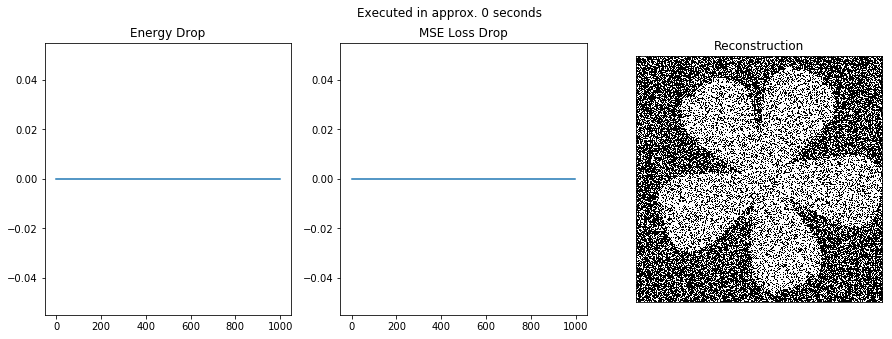

In [35]:
evaluate(parallel_tempering, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 5)

If you have experienced any implementation issues, this is the place to complain. Did you encounter any numerical or efficiency problems? If yes, how did you solve them? Any reasoning is appreciated.

### Your remarks:



## Problem 7

We now ask you to re-implement one of the sampling methods of your choice by changing the algorithm slighly (but not only parameters such as e.g. initial temperature $T$). One can for example, in metropolis scheme try to order the evaluated pixels both sequentually and randomly. Also one can implement the simulated annealing with different annealing schedules: logarithmic, linear, quadratic etc. Explain what you change.

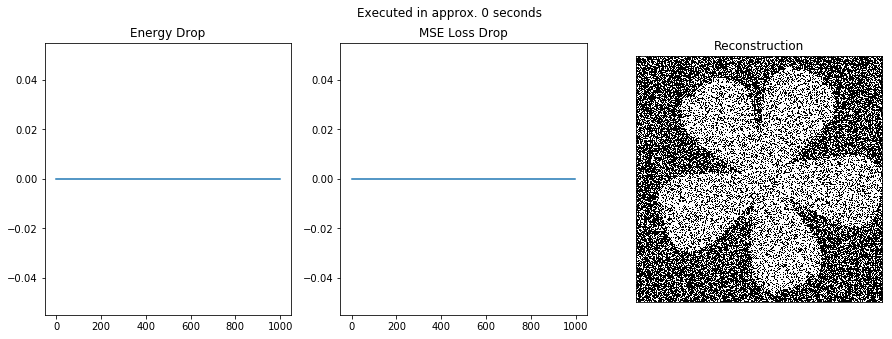

In [36]:
def your_method(img_noisy_observation, img_original, epochs):
    """Do the sampling starting from noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code
    energies = []
    losses = []
    E = energy(img_noisy_observation, img_noisy_observation)
    L = mse_loss(img_noisy_observation, img_original)
    # artifically construct energies and losses arrays
    for i in range(1000):
        energies.append(E)
        losses.append(L)
    return img_noisy_observation, np.asarray(energies), np.asarray(losses)

# Evaluate your method
evaluate(your_method, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 5)

# Extension: sampling from expectations

Solve this for an additional point. Note that solving only this part will give you 0 points, so you need to solve previous problems before doing this one.

## Task

In the image reconstruction problem above we have been trying to identify state with minimal energy i.e. the maximum a posteriori probability.

Another application of MCMC is to compute the expected value of a random variable - as for instance in Restricted Boltzmann Machines (RBMs), which allow for efficient Gibbs Sampling. Please refer to [3] for more details about them, even the code is provided. RBMs played a crucial role in the early development of deep learning (early as 2006 early).

We ask you to implement an RBM using the MNIST data set from last time and apply Locally Linear embedding to the representations obtained from the RBM. Does your embedding get better? You may also try to stack RBMs as described in the reference and see how the embedding changes as you get higher level representations.

It is enough to provide and explain several plots to compare the quality of embeddings of LLE and RBM+LLE models. You may use the sklearn implementation of LLE in case you skipped the previous exercise.

### References

[3] http://deeplearning.net/tutorial/rbm.html

# Extra Comments?

If there is anything that you liked or disliked in this exercise, please let us now by noting that down in the following box. This will help us improve our future exercises. Thank you in advance!